### **Importing libraries**

In [2]:
import pandas as pd
# from sklearn.model_selection import train_test_split
# from utils import *
import os
import csv
import torch

Reading dataset

In [3]:
TrainingData = pd.read_csv('TrainingData.csv')
TestingData = pd.read_csv('TestingData.csv')
print(TrainingData.shape)
print(TestingData.shape)



(18165, 2)
(4515, 2)


In [4]:
TrainingData.head()

,y,x
0,1,1_10_rotate_10.jpeg
1,2,2_10_rotate_10.jpeg
2,3,3_10_rotate_10.jpeg
3,4,4_10_rotate_10.jpeg
4,5,5_10_rotate_10.jpeg


In [4]:
TestingData.head()

,y,x
0,1,1_58_rotate_10.jpeg
1,2,2_58_rotate_10.jpeg
2,3,3_58_rotate_10.jpeg
3,4,4_58_rotate_10.jpeg
4,5,5_58_rotate_10.jpeg


**Ordinal Encoding for y**

In [5]:
# classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
#  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
#   'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# from sklearn.preprocessing import OrdinalEncoder
# ordinal = OrdinalEncoder(categories=[classes])
# encoded = ordinal.fit_transform(y_train[[0]])
# ytrain = pd.DataFrame(encoded,columns=['y'])
# ytrain.shape
# type(ytrain)

## **Image Processing**

***Function for Loading data***

In [5]:
import numpy as np
def loadData(path, data):
  imagesPath = []
  for i in range(data.size):
    imagesPath.append(f'{path}/{data.iloc[i][0][0]}/{data.iloc[i]}')
  imagesPath = np.asarray(imagesPath)
  return imagesPath

***Loading xTrain, yTrain and xTest, yTest***

In [6]:
path = 'asl'
xTrain = pd.DataFrame(loadData(path, TrainingData['x']))
yTrain = TrainingData['y']

xTest = pd.DataFrame(loadData(path, TestingData['x']))
yTest = TestingData['y']

print('xTrain: ',len(xTrain))
print('yTrain: ',len(yTrain))

print('xTest: ',len(xTest))
print('yTest: ',len(yTest))
# xTrain
# yTrain

xTrain:  18165
yTrain:  18165
xTest:  4515
yTest:  4515


***Funciton for image preprocessing***

In [7]:
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import cv2
import random
from PIL import Image
import time

def preProcess(img):
    
    img = cv2.resize(img, (200, 200))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # img = cv2.GaussianBlur(img,  (3, 3), 0)
    # im = Image.fromarray(img)
    # im.show()
    # time.sleep(1)
    # img = img/255

    
    img = tf.keras.utils.normalize(img, axis = 1) #normalizing data

    return img

***Function for Batch Generation***

In [8]:
def batchGen(imagesPath, labelList, batchSize, trainFlag):
    while True:
        imgBatch = []
        labelBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)            
            img = mpimg.imread(imagesPath[0][index])
            img = preProcess(img)
            label = labelList[index]
            imgBatch.append(img)
            labelBatch.append(label)
        yield (np.asarray(imgBatch), np.asarray(labelBatch))

In [9]:
# Function testing
img = mpimg.imread(xTrain[0][1500])
type(img)

numpy.ndarray

In [10]:
yTrain[0]

1

### **CNN Model**

In [11]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Convolution2D,Flatten,Dense
from keras.optimizers import Adam
import tensorflow as tf

In [40]:
def createModel():
    model = Sequential()

    # # The inputs are 66x200x3(RGB) images with `channels_last` and the batch size is 24.
    # For CNNs that are trained on images, for example, say your dataset is RGB (3-channel) images that are 256x256
    # pixels. A single image can be represented by a 3 x 256 x 256 matrix.If you set your batch size to be 10, that
    # means you’re concatenating 10 images together into a 10 x 3 x 256 x 256 matrix.

    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(200, 200, 1), activation='relu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='relu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(36, activation = 'softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

    return model

### ***Training model***

In [41]:
model = createModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 98, 98, 24)        624       
                                                                 
 conv2d_11 (Conv2D)          (None, 47, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 22, 22, 48)        43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 64)        27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 20736)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

Epoch 1/10
300/300 [==============================] - 532s 2s/step - loss: 0.3348 - accuracy: 0.8876
Epoch 2/10
300/300 [==============================] - 502s 2s/step - loss: 0.0706 - accuracy: 0.9764
Epoch 3/10
300/300 [==============================] - 468s 2s/step - loss: 0.0322 - accuracy: 0.9896
Epoch 4/10
300/300 [==============================] - 445s 1s/step - loss: 0.0207 - accuracy: 0.9942
Epoch 5/10
300/300 [==============================] - 412s 1s/step - loss: 0.0249 - accuracy: 0.9924
Epoch 6/10
300/300 [==============================] - 395s 1s/step - loss: 0.0259 - accuracy: 0.9924
Epoch 7/10
300/300 [==============================] - 413s 1s/step - loss: 0.0157 - accuracy: 0.9954
Epoch 8/10
300/300 [==============================] - 414s 1s/step - loss: 0.0169 - accuracy: 0.9953
Epoch 9/10
300/300 [==============================] - 385s 1s/step - loss: 0.0157 - accuracy: 0.9951
Epoch 10/10
300/300 [==============================] - 384s 1s/step - loss: 0.0104 - accura

KeyError: 'val_loss'

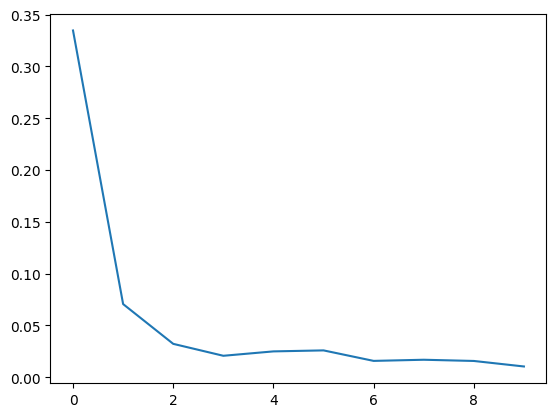

In [44]:
model.fit(batchGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10)

model.save('signLanguage.h5')
print('Model Saved')

In [13]:
Model = tf.keras.models.load_model('signLanguage.h5')

In [12]:
def Gen(imagesPath, labelList):
    while True:
        imgBatch = []
        labelBatch = []

        # for i in range(len(imagesPath)):
        for i in range(100):
            index = random.randint(0, len(imagesPath) - 1)            
            img = mpimg.imread(imagesPath[0][index])
            img = preProcess(img)
            label = labelList[index]
            imgBatch.append(img)
            labelBatch.append(label)
        return (np.asarray(imgBatch), np.asarray(labelBatch))


In [14]:
x = Gen(xTest, yTest)

In [150]:
# x[0]

In [151]:
loss, accuracy = Model.evaluate(x[0],x[1])
print(loss)
print(accuracy)

142/142 [==============================] - 16s 108ms/step - loss: 2.9536 - accuracy: 0.7103
2.953555107116699
0.710299015045166


In [149]:
# import seaborn as sn
# cm = tf.math.confusion_matrix(labels = yTest, predictions = y_predicted_labels)
# plt.figure(figsize = (10, 7))
# sn.heatmap(cm, annot = True, fmt = 'd')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

In [15]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
  'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

(1, 200, 200)
1/1 [==============================] - 0s 38ms/step
[[0.0000000e+00 1.5149319e-31 1.2658698e-38 8.1222174e-25 4.5447950e-34
  2.5097261e-30 0.0000000e+00 2.2573457e-38 5.0923685e-22 0.0000000e+00
  3.5526482e-21 0.0000000e+00 6.7449317e-21 6.7236063e-37 1.1361069e-26
  0.0000000e+00 1.0594608e-34 5.8901778e-35 2.1406409e-36 0.0000000e+00
  0.0000000e+00 1.0000000e+00 1.0181074e-28 3.9130159e-28 9.6118887e-37
  5.7089429e-32 5.6584570e-36 0.0000000e+00 4.2486858e-37 3.4567866e-26
  0.0000000e+00 1.2234324e-37 0.0000000e+00 8.0212970e-37 3.5335494e-29
  6.2695005e-31]]
this sign is probably a l
actual sign is = l


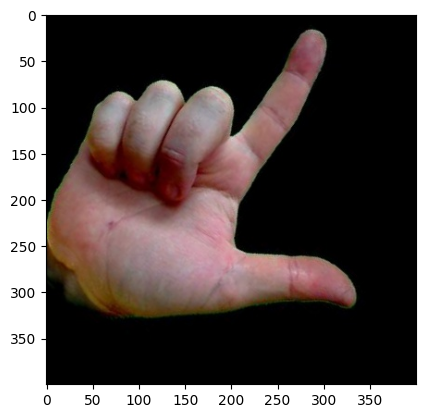

In [19]:
n = 405

img = mpimg.imread(xTest[0][n])
img2 = preProcess(img)
img2 = np.expand_dims(img2, axis=0)
print(img2.shape)

prediction = Model.predict(img2)
print(prediction)
prediction = np.argmax(prediction)
print(f"this sign is probably a {labels[prediction]}")
actual = yTest[n]
print('actual sign is =', labels[actual])
imgplot = plt.imshow(img)
# plt.show()